In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

For this assignment, I will use data from Airbnb activity in Seattle. I will use a linear regression as well as a k-nearest neighbors model to model the factors that predict price, and compare the performance of the two models.

In [2]:
#load data
airbnb_df = pd.read_csv('listings.csv')

In [3]:
#get data information
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

From the above, we can see that this dataset has 30 numeric variables and 62 string object type variables; however, some variables that we would expect to be numeric, like price are instead object-type variables. We should convert these variables to floats to use them in our model.

In [4]:
#convert price variables to numeric
cols_to_numeric = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee']
for col in cols_to_numeric:
    airbnb_df[col] = airbnb_df[col].str.replace('$', '')
    airbnb_df[col] = airbnb_df[col].str.replace(',', '')
    airbnb_df[col] = airbnb_df[col].apply(lambda x: float(x))

In [5]:
#check for missing data
for col in airbnb_df.columns:
    print(col, airbnb_df[col].isnull().sum()*100/airbnb_df[col].isnull().count())

id 0.0
listing_url 0.0
scrape_id 0.0
last_scraped 0.0
name 0.0
summary 4.6359350445259295
space 14.903090623363017
description 0.0
experiences_offered 0.0
neighborhood_overview 27.02985856469356
notes 42.063907805133574
transit 24.463069669984286
thumbnail_url 8.381351492928236
medium_url 8.381351492928236
picture_url 0.0
xl_picture_url 8.381351492928236
host_id 0.0
host_url 0.0
host_name 0.05238344683080147
host_since 0.05238344683080147
host_location 0.20953378732320588
host_about 22.49869041382923
host_response_time 13.698271346254584
host_response_rate 13.698271346254584
host_acceptance_rate 20.24620220010477
host_is_superhost 0.05238344683080147
host_thumbnail_url 0.05238344683080147
host_picture_url 0.05238344683080147
host_neighbourhood 7.85751702462022
host_listings_count 0.05238344683080147
host_total_listings_count 0.05238344683080147
host_verifications 0.0
host_has_profile_pic 0.05238344683080147
host_identity_verified 0.05238344683080147
street 0.0
neighbourhood 10.89575694

There are a number of columns that are missing a lot of data. Some columns, like square feet and monthly price are missing too much data for it to be reasonable to include them in a model. Several columns are missing a portion of the data that could more reasonably be dropped or replaced, so if we choose to use any of those columns in our model, we will have to address this missing data.

In [6]:
#get correlation between variables
airbnb_df.corr()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
id,1.000000,NaN,0.546514,-0.023312,-0.023312,-0.016143,0.013360,-0.074279,-0.061821,-0.064113,...,0.039246,0.045355,0.068112,-0.004710,0.003389,0.105444,0.087858,NaN,-0.051348,0.091716
scrape_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_id,0.546514,NaN,1.000000,-0.069613,-0.069613,-0.024217,0.014749,-0.099620,-0.057076,-0.075722,...,0.027348,0.026768,0.047576,0.022116,0.025023,0.073277,0.078829,NaN,-0.176040,0.106389
host_listings_count,-0.023312,NaN,-0.069613,1.000000,1.000000,-0.012511,-0.000055,0.111210,0.068226,0.065931,...,-0.109357,-0.122957,-0.044087,-0.190730,-0.137222,0.024161,-0.114171,NaN,0.224222,-0.117272
host_total_listings_count,-0.023312,NaN,-0.069613,1.000000,1.000000,-0.012511,-0.000055,0.111210,0.068226,0.065931,...,-0.109357,-0.122957,-0.044087,-0.190730,-0.137222,0.024161,-0.114171,NaN,0.224222,-0.117272
latitude,-0.016143,NaN,-0.024217,-0.012511,-0.012511,1.000000,-0.155092,0.000335,-0.015003,0.039100,...,-0.038086,-0.015072,-0.038183,-0.018381,-0.025117,0.096746,-0.019488,NaN,0.026750,-0.084988
longitude,0.013360,NaN,0.014749,-0.000055,-0.000055,-0.155092,1.000000,-0.071584,-0.017041,-0.055045,...,-0.047121,-0.037005,-0.062576,-0.046990,-0.061539,-0.190567,-0.043979,NaN,0.086343,0.002583
accommodates,-0.074279,NaN,-0.099620,0.111210,0.111210,0.000335,-0.071584,1.000000,0.538439,0.770974,...,-0.013101,-0.049665,0.011646,-0.019664,-0.013208,-0.037520,-0.062041,NaN,-0.029525,-0.144150
bathrooms,-0.061821,NaN,-0.057076,0.068226,0.068226,-0.015003,-0.017041,0.538439,1.000000,0.610937,...,0.045101,-0.006129,0.018063,-0.002939,-0.016067,-0.008959,0.014297,NaN,-0.002731,-0.167894
bedrooms,-0.064113,NaN,-0.075722,0.065931,0.065931,0.039100,-0.055045,0.770974,0.610937,1.000000,...,0.023257,-0.011943,-0.008089,0.010509,0.001113,-0.028991,-0.001208,NaN,-0.045543,-0.230287


In [7]:
#limit data to features with highest correlations
airbnb_df[['price', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
          'security_deposit', 'cleaning_fee', 'guests_included', 'reviews_per_month']].corr()

,price,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,guests_included,reviews_per_month
price,1.000000,0.652218,0.516424,0.627720,0.589525,0.373195,0.656938,0.392875,-0.218588
accommodates,0.652218,1.000000,0.538439,0.770974,0.861119,0.285680,0.657223,0.532796,-0.144150
bathrooms,0.516424,0.538439,1.000000,0.610937,0.532838,0.299458,0.545006,0.304780,-0.167894
bedrooms,0.627720,0.770974,0.610937,1.000000,0.753167,0.331019,0.622305,0.457009,-0.230287
beds,0.589525,0.861119,0.532838,0.753167,1.000000,0.292765,0.626595,0.460512,-0.149079
security_deposit,0.373195,0.285680,0.299458,0.331019,0.292765,1.000000,0.436543,0.233586,-0.140299
cleaning_fee,0.656938,0.657223,0.545006,0.622305,0.626595,0.436543,1.000000,0.332619,-0.303313
guests_included,0.392875,0.532796,0.304780,0.457009,0.460512,0.233586,0.332619,1.000000,-0.028903
reviews_per_month,-0.218588,-0.144150,-0.167894,-0.230287,-0.149079,-0.140299,-0.303313,-0.028903,1.000000


In [8]:
#look at number of unique values for categorical variables
categorical = airbnb_df.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

listing_url
3818
last_scraped
1
name
3792
summary
3478
space
3119
description
3742
experiences_offered
1
neighborhood_overview
2506
notes
1999
transit
2574
thumbnail_url
3498
medium_url
3498
picture_url
3818
xl_picture_url
3498
host_url
2751
host_name
1466
host_since
1380
host_location
120
host_about
2011
host_response_time
4
host_response_rate
45
host_acceptance_rate
2
host_is_superhost
2
host_thumbnail_url
2743
host_picture_url
2743
host_neighbourhood
102
host_verifications
116
host_has_profile_pic
2
host_identity_verified
2
street
1442
neighbourhood
81
neighbourhood_cleansed
87
neighbourhood_group_cleansed
17
city
7
state
2
zipcode
28
market
1
smart_location
7
country_code
1
country
1
is_location_exact
2
property_type
16
room_type
3
bed_type
5
amenities
3284
extra_people
45
calendar_updated
34
has_availability
1
calendar_last_scraped
1
first_review
984
last_review
321
requires_license
1
jurisdiction_names
1
instant_bookable
2
cancellation_policy
3
require_guest_profile_picture
2
req

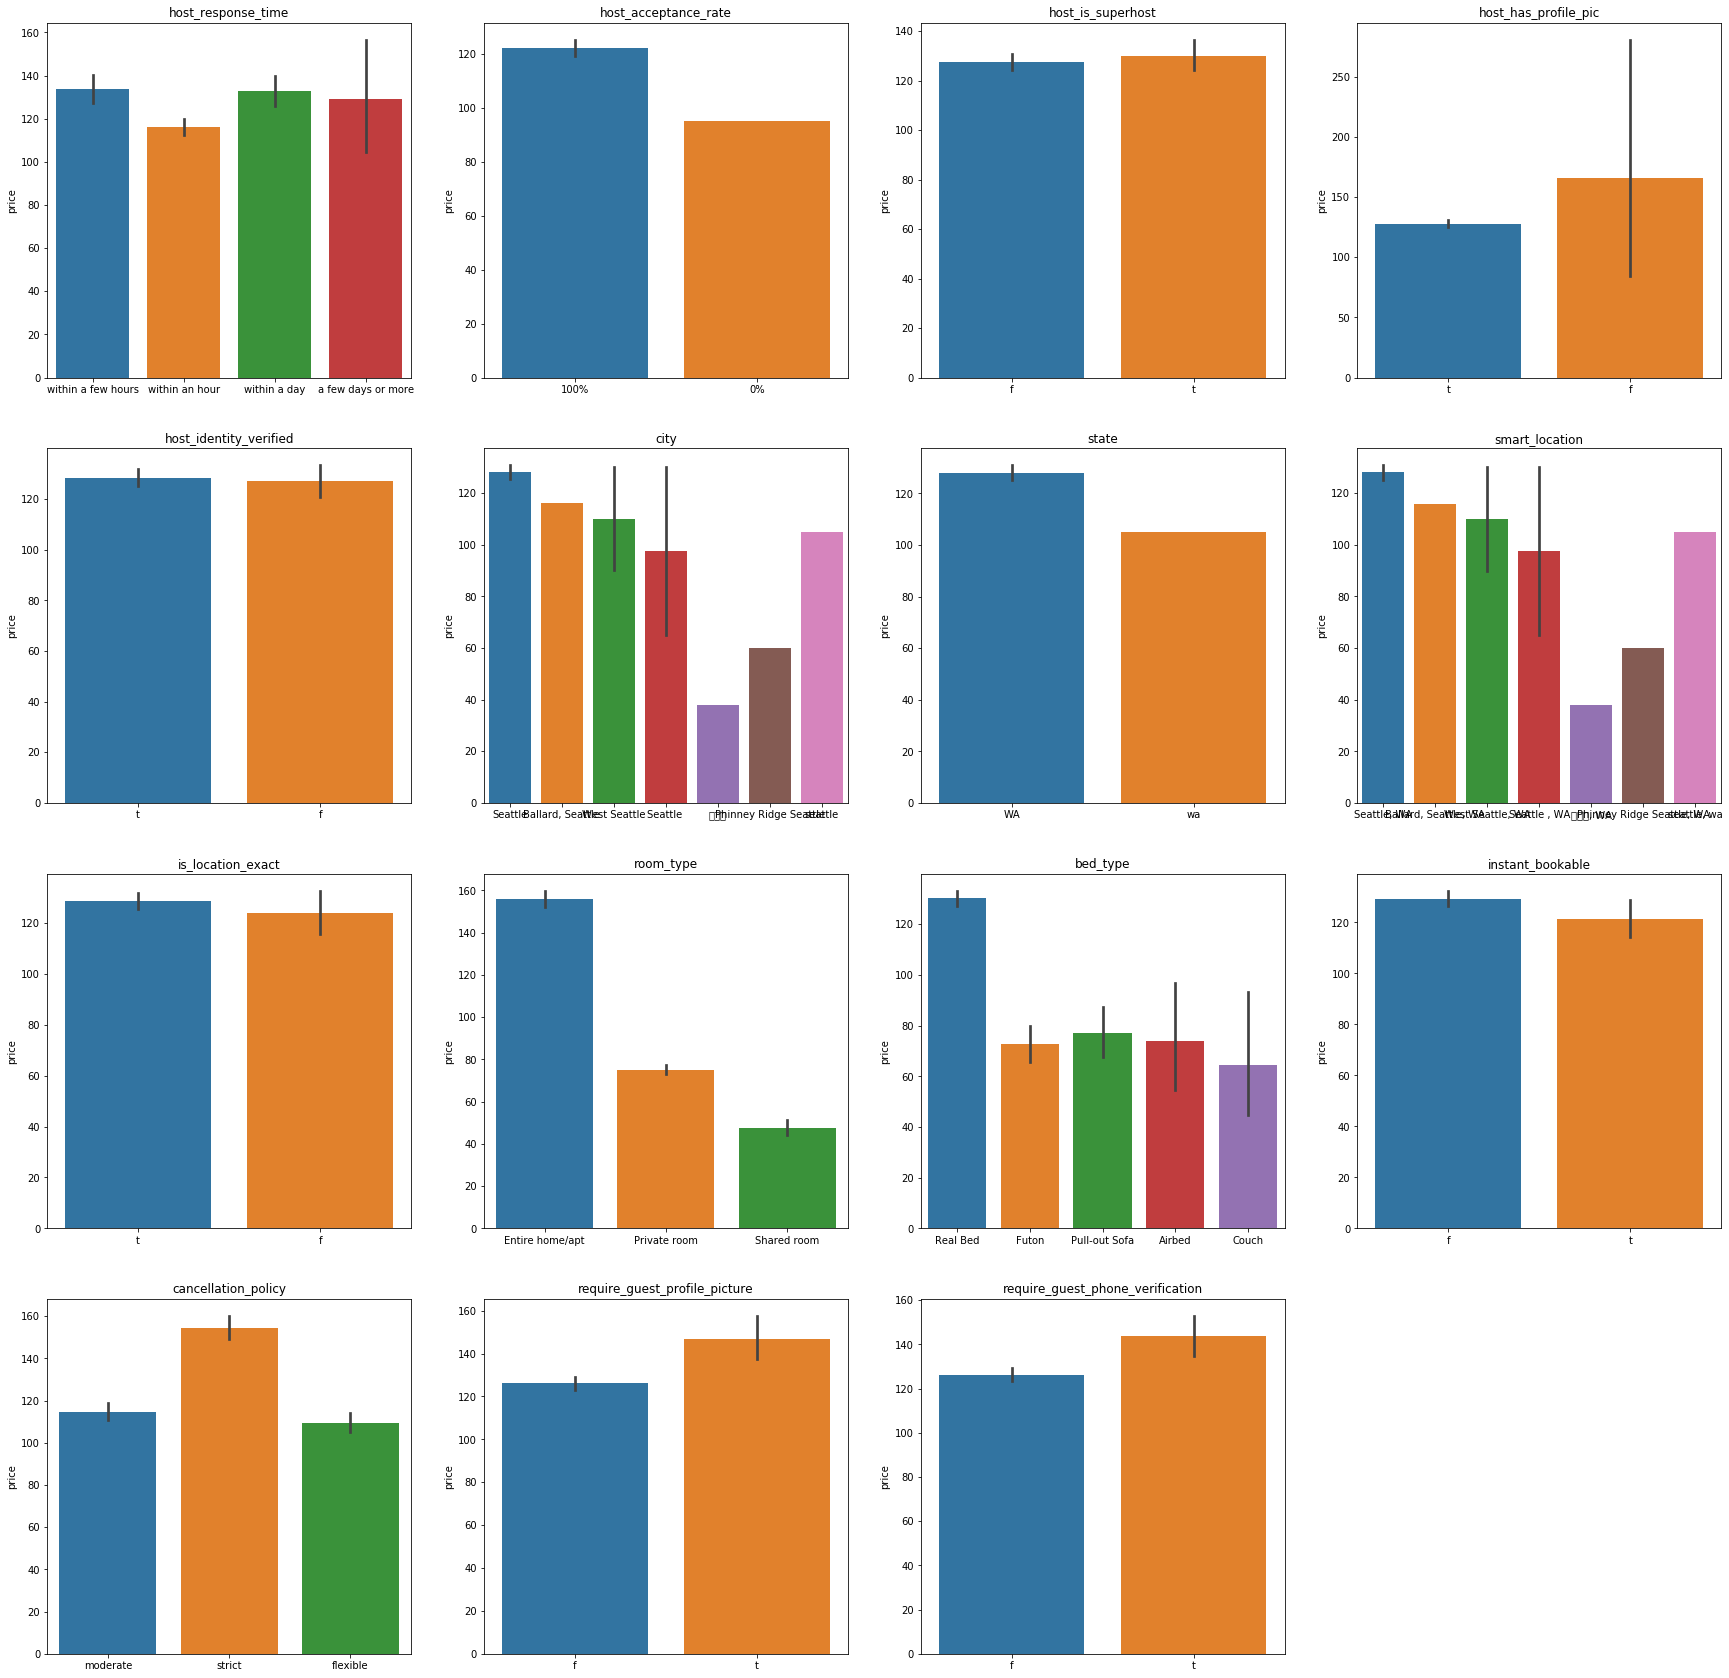

In [9]:
#select categorical variables with less than 10 unique values
categories = ['host_response_time', 'host_acceptance_rate', 'host_is_superhost',
             'host_has_profile_pic', 'host_identity_verified', 'city', 'state', 'smart_location',
             'is_location_exact', 'room_type', 'bed_type',
              'instant_bookable', 'cancellation_policy', 
              'require_guest_profile_picture', 'require_guest_phone_verification']
#plot selected variables to compare with price
plt.figure(figsize=(30,30))
for index, var in enumerate(categories):
    plt.subplot(4, 4, index+1)
    sns.barplot(airbnb_df[var], airbnb_df['price'])
    plt.title(var)
    plt.xlabel('')

plt.show()

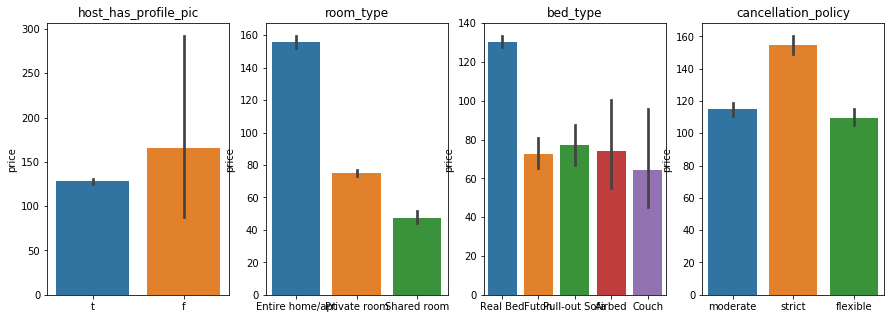

In [10]:
#select variables with most significant differences between groups
categories = ['host_has_profile_pic', 'room_type', 'bed_type', 'cancellation_policy']
plt.figure(figsize=(15,5))
for index, var in enumerate(categories):
    plt.subplot(1, 4, index+1)
    sns.barplot(airbnb_df[var], airbnb_df['price'])
    plt.title(var)
    plt.xlabel('')

plt.show()

In [11]:
#check for missing data in selected columns
regression_columns = ['price', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
          'security_deposit', 'cleaning_fee', 'guests_included', 'reviews_per_month', 
            'host_has_profile_pic', 'room_type', 'bed_type', 'cancellation_policy']
for col in regression_columns:
    print(col, airbnb_df[col].isnull().sum()*100/airbnb_df[col].isnull().count())

price 0.0
accommodates 0.0
bathrooms 0.41906757464641176
bedrooms 0.1571503404924044
beds 0.026191723415400735
security_deposit 51.12624410686223
cleaning_fee 26.977475117862756
guests_included 0.0
reviews_per_month 16.42221058145626
host_has_profile_pic 0.05238344683080147
room_type 0.0
bed_type 0.0
cancellation_policy 0.0


After looking at the correlation between numerical variables and plotting the categorical variables, I have selected the variables that are most highly correlated with price. Now we need to address missing data for these variables. For security deposit and cleaning fee, we can logically assume that a null value means that there is no security deposit/cleaning fee, and go ahead and replace these values with 0. For reviews per month, we will also assume that a null value means that there are no reviews and replace that value with 0 as well. For bathrooms, bedrooms, beds, and host has profile pic, very little data is missing, so we will drop that data based on the assumption that we will not lose much information.

In [12]:
#fill na values with 0
airbnb_df['security_deposit'] = airbnb_df['security_deposit'].fillna(0)
airbnb_df['cleaning_fee'] = airbnb_df['cleaning_fee'].fillna(0)
airbnb_df['reviews_per_month'] = airbnb_df['reviews_per_month'].fillna(0)
#drop na values
airbnb_df = airbnb_df.dropna(subset = ['bathrooms', 'bedrooms', 'beds', 'host_has_profile_pic'])

In [13]:
#confirm null values have been dropped or replaced
regression_columns = ['price', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
          'security_deposit', 'cleaning_fee', 'guests_included', 'reviews_per_month', 
            'host_has_profile_pic', 'room_type', 'bed_type', 'cancellation_policy']
for col in regression_columns:
    print(col, airbnb_df[col].isnull().sum()*100/airbnb_df[col].isnull().count())

price 0.0
accommodates 0.0
bathrooms 0.0
bedrooms 0.0
beds 0.0
security_deposit 0.0
cleaning_fee 0.0
guests_included 0.0
reviews_per_month 0.0
host_has_profile_pic 0.0
room_type 0.0
bed_type 0.0
cancellation_policy 0.0


In [14]:
#create dummy variables for the linear regression
airbnb_df['profile_pic'] = pd.get_dummies(airbnb_df.host_has_profile_pic, drop_first=True)
airbnb_df = pd.concat([airbnb_df,pd.get_dummies(airbnb_df.room_type, prefix='room_type', drop_first=True)], axis=1)
room_column_names = list(pd.get_dummies(airbnb_df.room_type, prefix='room_type', drop_first=True).columns)
airbnb_df = pd.concat([airbnb_df,pd.get_dummies(airbnb_df.bed_type, prefix='bed_type', drop_first=True)], axis=1)
bed_column_names = list(pd.get_dummies(airbnb_df.bed_type, prefix='bed_type', drop_first=True).columns)
airbnb_df = pd.concat([airbnb_df,pd.get_dummies(airbnb_df.cancellation_policy, prefix='cancellation_policy', drop_first=True)], axis=1)
cancellation_column_names = list(pd.get_dummies(airbnb_df.cancellation_policy, prefix='cancellation_policy', drop_first=True).columns)

In [15]:
#fit linear model
#target variable
Y = airbnb_df['price']
#feature set
X = airbnb_df[['accommodates', 'bathrooms', 'bedrooms', 'beds',
          'security_deposit', 'cleaning_fee', 'guests_included', 'reviews_per_month', 'profile_pic'] + room_column_names +
             bed_column_names + cancellation_column_names]

#define linear model
X = sm.add_constant(X)

linear_model = LinearRegression()
linear_model.fit(X, Y)

score = cross_val_score(linear_model, X, Y, cv=5)
print("R-Squared Value for Linear Model: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

R-Squared Value for Linear Model: 0.52 (+/- 0.18)


In [16]:
#take z-scores of variables and implement knn
X = pd.DataFrame({'accommodates': stats.zscore(airbnb_df['accommodates']), 'bathrooms': stats.zscore(airbnb_df['bathrooms']),
                 'bedrooms': stats.zscore(airbnb_df['bedrooms']), 'beds': stats.zscore(airbnb_df['beds']), 
                  'security_deposit': stats.zscore(airbnb_df['security_deposit']), 'cleaning_fee': stats.zscore(airbnb_df['cleaning_fee']),
                 'guests_included': stats.zscore(airbnb_df['guests_included']), 'reviews_per_month': stats.zscore(airbnb_df['reviews_per_month']),
                 'profile_pic': stats.zscore(airbnb_df['profile_pic']), 'private_room': stats.zscore(airbnb_df['room_type_Private room']),
                 'shared_room': stats.zscore(airbnb_df['room_type_Shared room']), 'couch': stats.zscore(airbnb_df['bed_type_Couch']),
                 'futon': stats.zscore(airbnb_df['bed_type_Futon']), 'sofa': stats.zscore(airbnb_df['bed_type_Pull-out Sofa']),
                 'bed': stats.zscore(airbnb_df['bed_type_Real Bed']), 'moderate_cancellation': stats.zscore(airbnb_df['cancellation_policy_moderate']),
                  'strict_cancellation': stats.zscore(airbnb_df['cancellation_policy_strict'])})
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
knn.fit(X, Y)

score = cross_val_score(knn, X, Y, cv=5)
print("R-Squared Value for Unweighted KNN Model: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

R-Squared Value for Unweighted KNN Model: 0.51 (+/- 0.16)


In [17]:
knn = neighbors.KNeighborsRegressor(n_neighbors=10, weights = 'distance')
knn.fit(X, Y)

score = cross_val_score(knn, X, Y, cv=5)
print("R-Squared Value for Weighted KNN Model: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

R-Squared Value for Weighted KNN Model: 0.51 (+/- 0.16)


Overall, the two models for this data had very similar performance; however, this model has fairly poor performance overall. If we were to use this data in a professional context, we would want to add more features to the model or engineer new features to use in our models. For the purposes of this assignment, this model performance is sufficient. It makes sense that the two models would perform very similarly. A lot of the factors that we incorporated into the model indicate that the Airbnb can hold a lot of people, allowing them to charge more for that listing. Some of the features that we included in the model have a high correlation with the price of the listing, and it makes a lot of sense that nearest neighbors would have a similar performance to a linear model because listings with similar characteristics should have similar prices.